# exploring survey study with bears
blaba

In [20]:
import razorback as rb
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
def sensor(ats_file):
    header = rb.io.ats.read_ats_header(ats_file)
    chan = header['channel_type'].decode()
    stype = ''.join(c for c in header['sensor_type'].decode() if c.isprintable())
    snum = header['sensor_serial_number']
    sampling_rate = header['sampling_rate']
    x1, y1, z1 = header['x1'], header['y1'], header['z1']
    x2, y2, z2 = header['x2'], header['y2'], header['z2']
    L = ((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)**.5
    return chan, L, stype, snum, sampling_rate

In [3]:
def calibration(ats_file, name_converter=None):
    chan, L, stype, snum, sampling_rate = sensor(ats_file)
    if chan in ('Ex', 'Ey'):
        return L
    elif chan in ('Hx', 'Hy', 'Hz'):
        calib_name = f"{stype}{snum:03d}.txt"
        if name_converter:
            calib_name = name_converter.get(calib_name, calib_name)
        return rb.calibrations.metronix(calib_name, sampling_rate)
    raise Exception(f"Unknown channel name: {chan}")

In [4]:
import glob

files = glob.glob("data/site*/*/*.ats")
pattern = "*/site{site}/*/*_T{channel}_*.ats"
tag_template = "site{site}_{channel}"

name_converter = {
    'UNKN_H104.txt': 'MFS07104.txt',
    'UNKN_H105.txt': 'MFS07105.txt',
}

inv = rb.Inventory()
for fname, [tag] in rb.utils.tags_from_path(files, pattern, tag_template):
    calib = calibration(fname, name_converter)
    signal = rb.io.ats.load_ats([fname], [calib], lazy=True)
    inv.append(rb.SignalSet({tag:0}, signal))

In [5]:
len(inv)

24

In [6]:
inv.tags

{'site002_Ex',
 'site002_Ey',
 'site002_Hx',
 'site002_Hy',
 'site002_Hz',
 'site004_Ex',
 'site004_Ey',
 'site004_Hx',
 'site004_Hy',
 'site004_Hz',
 'site006_Ex',
 'site006_Ey',
 'site006_Hx',
 'site006_Hy',
 'site006_Hz',
 'site009_Ex',
 'site009_Ey',
 'site009_Hx',
 'site009_Hy',
 'site009_Hz',
 'site099_Hx',
 'site099_Hy',
 'site100_Hx',
 'site100_Hy'}

In [7]:
print(inv.filter('site002*').pack())

SignalSet: 5 channels, 1 run
tags: {'site002_Ex': (0,), 'site002_Ey': (1,), 
       'site002_Hx': (2,), 'site002_Hy': (3,), 
       'site002_Hz': (4,)}
----------  -------------------  -------------------
  sampling                start                 stop
       128  2016-04-28 08:20:00  2016-04-29 06:46:22
----------  -------------------  -------------------


In [8]:
print(inv.filter('site099*').pack())

SignalSet: 2 channels, 1 run
tags: {'site099_Hx': (0,), 'site099_Hy': (1,)}
----------  -------------------  -------------------
  sampling                start                 stop
       128  2016-04-28 19:00:00  2016-04-29 17:59:00
----------  -------------------  -------------------


In [9]:
print(inv.pack())

SignalSet: 24 channels, 1 run
tags: {'site002_Ex': (0,), 'site002_Ey': (1,), 
       'site002_Hx': (2,), 'site002_Hy': (3,), 
       'site002_Hz': (4,), 'site004_Ex': (5,), 
       'site004_Ey': (6,), 'site004_Hx': (7,), 
       'site004_Hy': (8,), 'site004_Hz': (9,), 
       'site006_Ex': (10,), 'site006_Ey': (11,), 
       'site006_Hx': (12,), 'site006_Hy': (13,), 
       'site006_Hz': (14,), 'site009_Ex': (15,), 
       'site009_Ey': (16,), 'site009_Hx': (17,), 
       'site009_Hy': (18,), 'site009_Hz': (19,), 
       'site099_Hx': (20,), 'site099_Hy': (21,), 
       'site100_Hx': (22,), 'site100_Hy': (23,)}
----------  -------------------  -------------------
  sampling                start                 stop
       128  2016-04-28 19:00:00  2016-04-29 04:00:05
----------  -------------------  -------------------


In [10]:
from itertools import chain

def prepare_signalset(inventory, local_site, remote_sites):
    patterns = (f"{e}*" for e in [local_site, *remote_sites])
    signalset = inventory.filter(*patterns).pack()
    tags = signalset.tags
    tags["E"] = tags[f"{local_site}_Ex"] + tags[f"{local_site}_Ey"]
    tags["B"] = tags[f"{local_site}_Hx"] + tags[f"{local_site}_Hy"]
    if remote_sites:
        remote_names = tags.filter(*chain(*(
            (f"{e}_Hx", f"{e}_Hy") for e in remote_sites
        )))
        tags["Bremote"] = sum((tags[n] for n in remote_names), ())
    return signalset

In [11]:
print(prepare_signalset(inv, 'site002', ['site100', 'site099']))

SignalSet: 9 channels, 1 run
tags: {'site002_Ex': (0,), 'site002_Ey': (1,), 
       'site002_Hx': (2,), 'site002_Hy': (3,), 
       'site002_Hz': (4,), 'site099_Hx': (5,), 
       'site099_Hy': (6,), 'site100_Hx': (7,), 
       'site100_Hy': (8,), 'B': (2, 3), 
       'E': (0, 1), 'Bremote': (5, 7, 8, 6)}
----------  -------------------  -------------------
  sampling                start                 stop
       128  2016-04-28 19:00:00  2016-04-29 06:46:22
----------  -------------------  -------------------


defining a frequency array in logscale for TF computation

In [35]:
freq = np.logspace(-2, np.log10(32), 26)
print(freq)

[1.00000000e-02 1.38103918e-02 1.90726921e-02 2.63401351e-02
 3.63767585e-02 5.02377286e-02 6.93802715e-02 9.58168731e-02
 1.32326856e-01 1.82748572e-01 2.52382938e-01 3.48550725e-01
 4.81362207e-01 6.64780067e-01 9.18087317e-01 1.26791455e+00
 1.75103967e+00 2.41825439e+00 3.33970406e+00 4.61226215e+00
 6.36971473e+00 8.79682560e+00 1.21487608e+01 1.67779146e+01
 2.31709574e+01 3.20000000e+01]


In [40]:
#Computing simple two-stage OLS Impedance estimates for site002 with 2 distant remote

In [49]:
sig = prepare_signalset(inv, 'site002', ['site100', 'site099'])
print(sig)
Imp = rb.utils.impedance(sig, freq ,remote='Bremote' )
print(Imp.impedance.shape)

SignalSet: 9 channels, 1 run
tags: {'site002_Ex': (0,), 'site002_Ey': (1,), 
       'site002_Hx': (2,), 'site002_Hy': (3,), 
       'site002_Hz': (4,), 'site099_Hx': (5,), 
       'site099_Hy': (6,), 'site100_Hx': (7,), 
       'site100_Hy': (8,), 'B': (2, 3), 
       'E': (0, 1), 'Bremote': (5, 7, 8, 6)}
----------  -------------------  -------------------
  sampling                start                 stop
       128  2016-04-28 19:00:00  2016-04-29 06:46:22
----------  -------------------  -------------------
starting frequency 0.01
starting frequency 0.0138104
starting frequency 0.0190727
starting frequency 0.0263401
starting frequency 0.0363768
starting frequency 0.0502377
starting frequency 0.0693803
starting frequency 0.0958169
starting frequency 0.132327
starting frequency 0.182749
starting frequency 0.252383
starting frequency 0.348551
starting frequency 0.481362
starting frequency 0.66478
starting frequency 0.918087
starting frequency 1.26791
starting frequency 1.75104
start

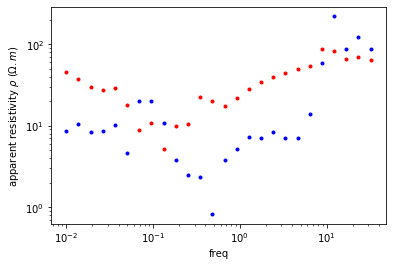

In [50]:
plt.loglog(freq,1e12*np.abs(Imp.impedance[:,0,1])**2/freq,'r.')
plt.loglog(freq,1e12*np.abs(Imp.impedance[:,1,0])**2/freq,'b.')
plt.xlabel('freq')
plt.ylabel(r'apparent resistivity $\rho$ ($\Omega.m$)');

In [54]:
from razorback.weights import bi_weights

sig = prepare_signalset(inv, 'site002', ['site100', 'site099'])
print(sig)
ImpBI = rb.utils.impedance(
    sig, freq,
     weights=bi_weights(0.1, 3),  # bounded influence with reject probability of 10% and 3 steps
    remote='Bremote' # including the remotes references in the coputation
)
print(ImpBI.impedance.shape)

SignalSet: 9 channels, 1 run
tags: {'site002_Ex': (0,), 'site002_Ey': (1,), 
       'site002_Hx': (2,), 'site002_Hy': (3,), 
       'site002_Hz': (4,), 'site099_Hx': (5,), 
       'site099_Hy': (6,), 'site100_Hx': (7,), 
       'site100_Hy': (8,), 'B': (2, 3), 
       'E': (0, 1), 'Bremote': (5, 7, 8, 6)}
----------  -------------------  -------------------
  sampling                start                 stop
       128  2016-04-28 19:00:00  2016-04-29 06:46:22
----------  -------------------  -------------------
starting frequency 0.01
Matrix is singular.
starting frequency 0.0138104


C:\Users\wawrzyniak\AppData\Local\Continuum\anaconda3\lib\site-packages\razorback\mestimator.py:304: LinAlgWarning: Ill-conditioned matrix (rcond=3.04044e-19): result may not be accurate.
  return linalg.solve(A, rhs)
C:\Users\wawrzyniak\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
C:\Users\wawrzyniak\AppData\Local\Continuum\anaconda3\lib\site-packages\razorback\weights.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.04044e-19): result may not be accurate.
  h = _prev['bi_weight'] * np.sum(linalg.solve(A, H(b)) * b.T, axis=0).real


Matrix is singular.
starting frequency 0.0190727


C:\Users\wawrzyniak\AppData\Local\Continuum\anaconda3\lib\site-packages\razorback\mestimator.py:304: LinAlgWarning: Ill-conditioned matrix (rcond=3.3398e-19): result may not be accurate.
  return linalg.solve(A, rhs)
C:\Users\wawrzyniak\AppData\Local\Continuum\anaconda3\lib\site-packages\razorback\weights.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.3398e-19): result may not be accurate.
  h = _prev['bi_weight'] * np.sum(linalg.solve(A, H(b)) * b.T, axis=0).real


Matrix is singular.
starting frequency 0.0263401
Matrix is singular.
starting frequency 0.0363768
Matrix is singular.
starting frequency 0.0502377
Matrix is singular.
starting frequency 0.0693803


C:\Users\wawrzyniak\AppData\Local\Continuum\anaconda3\lib\site-packages\razorback\mestimator.py:304: LinAlgWarning: Ill-conditioned matrix (rcond=1.54533e-20): result may not be accurate.
  return linalg.solve(A, rhs)
C:\Users\wawrzyniak\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
C:\Users\wawrzyniak\AppData\Local\Continuum\anaconda3\lib\site-packages\razorback\weights.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.54533e-20): result may not be accurate.
  h = _prev['bi_weight'] * np.sum(linalg.solve(A, H(b)) * b.T, axis=0).real
C:\Users\wawrzyniak\AppData\Local\Continuum\anaconda3\lib\site-packages\razorback\weights.py:120: RuntimeWarning: invalid value encountered in log
  hat_weight = _prev['hat_weight'] * expexp(y, self._khi) * expexp(np.log(y), np.log(self._lower))


Matrix is singular.
starting frequency 0.0958169


C:\Users\wawrzyniak\AppData\Local\Continuum\anaconda3\lib\site-packages\razorback\mestimator.py:304: LinAlgWarning: Ill-conditioned matrix (rcond=2.00717e-18): result may not be accurate.
  return linalg.solve(A, rhs)
C:\Users\wawrzyniak\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
C:\Users\wawrzyniak\AppData\Local\Continuum\anaconda3\lib\site-packages\razorback\weights.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.00717e-18): result may not be accurate.
  h = _prev['bi_weight'] * np.sum(linalg.solve(A, H(b)) * b.T, axis=0).real


Matrix is singular.
starting frequency 0.132327


C:\Users\wawrzyniak\AppData\Local\Continuum\anaconda3\lib\site-packages\razorback\mestimator.py:304: LinAlgWarning: Ill-conditioned matrix (rcond=1.93081e-18): result may not be accurate.
  return linalg.solve(A, rhs)
C:\Users\wawrzyniak\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
C:\Users\wawrzyniak\AppData\Local\Continuum\anaconda3\lib\site-packages\razorback\weights.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.93081e-18): result may not be accurate.
  h = _prev['bi_weight'] * np.sum(linalg.solve(A, H(b)) * b.T, axis=0).real


Matrix is singular.
starting frequency 0.182749
Matrix is singular.
starting frequency 0.252383
Matrix is singular.
starting frequency 0.348551
failed to converge (maxit=100). while processing step 3 (weighting=1).
starting frequency 0.481362
failed to converge (maxit=100). while processing step 3 (weighting=1).
starting frequency 0.66478
failed to converge (maxit=100). while processing step 3 (weighting=1).
starting frequency 0.918087
Matrix is singular.
starting frequency 1.26791
failed to converge (maxit=100). while processing step 3 (weighting=1).
starting frequency 1.75104
Matrix is singular.
starting frequency 2.41825
failed to converge (maxit=100). while processing step 3 (weighting=1).
starting frequency 3.3397
failed to converge (maxit=100). while processing step 3 (weighting=1).
starting frequency 4.61226
failed to converge (maxit=100). while processing step 3 (weighting=1).
starting frequency 6.36971
failed to converge (maxit=100). while processing step 3 (weighting=1).
star